In [28]:
# %%
import sys; sys.path.append("../") # For relative imports

import glob
import os
import pickle

from utils.conformal_utils import *
from utils.experiment_utils import get_inputs_folder, get_outputs_folder, get_figs_folder
from scipy.ndimage import uniform_filter


plt.rcParams.update({
    'font.size': 16,        # base font size
    'axes.titlesize': 18,   # subplot titles
    'axes.labelsize': 16,   # x/y labels
    'legend.fontsize': 16,  # legend text
    'xtick.labelsize': 22,  # tick labels
    'ytick.labelsize': 22,

})
# use tex with matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


dataset_names = {
    "plantnet": "Pl@ntNet-300K",
    "plantnet-trunc": "Pl@ntNet-300K-truncated",
    "inaturalist": "iNaturalist-2018",
    "inaturalist-trunc": "iNaturalist-2018-truncated",
}


In [31]:
# %%
## Choose dataset to create figures for
# dataset = 'plantnet'
# dataset = 'plantnet-trunc'
# dataset = 'inaturalist'
dataset = 'inaturalist-trunc'

# methods = ['standard', 'classwise', 'prevalence-adjusted'] 
methods = [f'cvx-cw_weight={tau}' for tau in [0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99 , 0.999, 1]]
print(methods)


alphas = [0.2, 0.1, 0.05, 0.01]

score = 'softmax'


# Load in paths from folders.json
results_folder = get_outputs_folder()
fig_folder = get_figs_folder()

os.makedirs(f'{fig_folder}/{dataset}', exist_ok=True)

# %%
f'{fig_folder}/{dataset}'

# %%
# Load test labels
test_labels = np.load(f'/home-warm/plantnet/conformal_cache/train_models/best-{dataset}-model_test_labels.npy')
num_classes = np.max(test_labels) + 1

# %%

# Load metrics

def load_metrics(dataset, alpha, method_name, score='softmax'):
    with open(f'{results_folder}/{dataset}_{score}_alpha={alpha}_{method_name}.pkl', 'rb') as f:
        metrics = pickle.load(f)
    # Extract set size quantiles for easy access later
    metrics['set_size_metrics']['median'] = metrics['set_size_metrics']['[.25, .5, .75, .9] quantiles'][1]
    metrics['set_size_metrics']['quantile90'] = metrics['set_size_metrics']['[.25, .5, .75, .9] quantiles'][3]
    return metrics


all_res = {}

for alpha in alphas:
    res = {}
    for method in methods:
        # print(method)
        res[method] = load_metrics(dataset, alpha, method)
    all_res[f'alpha={alpha}'] = res

# %%
def compute_class_cond_decision_accuracy(labels, is_covered, raw_set_sizes):
    # (assuming a random decision maker)
    num_classes = np.max(labels) + 1
    decision_acc = np.zeros((num_classes,))
    for k in range(num_classes):
        idx = labels == k
        # P(choose correct label) = 0 if label not in set
        # P(choose correct label) = 1/(set size) if label in set
        p_correct = is_covered[idx] * (1/raw_set_sizes[idx])
        p_correct[np.isnan(p_correct)] = 0 # nans are due to empty sets, so replace with 0
        decision_acc[k] = np.mean(p_correct)
        if np.isnan(decision_acc[k]):
            pdb.set_trace()

    return decision_acc

def compute_class_cond_decision_accuracy_for_method(res, method, labels):
    is_covered = res[method]['coverage_metrics']['is_covered']
    raw_set_sizes = res[method]['coverage_metrics']['raw_set_sizes']
    
    return compute_class_cond_decision_accuracy(labels, is_covered, raw_set_sizes)


# %%
# Add class-conditional decision accuracies to metrics
for res in all_res.values():
    for method in methods:
        dec_acc = compute_class_cond_decision_accuracy_for_method(res, method, test_labels)
        res[method]['class-cond-decision-accuracy'] = dec_acc


['cvx-cw_weight=0', 'cvx-cw_weight=0.25', 'cvx-cw_weight=0.5', 'cvx-cw_weight=0.75', 'cvx-cw_weight=0.9', 'cvx-cw_weight=0.95', 'cvx-cw_weight=0.975', 'cvx-cw_weight=0.99', 'cvx-cw_weight=0.999', 'cvx-cw_weight=1']


/tmp/ipykernel_2052273/1582642498.py:63: RuntimeWarning: divide by zero encountered in divide
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])
/tmp/ipykernel_2052273/1582642498.py:63: RuntimeWarning: invalid value encountered in multiply
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])


/tmp/ipykernel_2052273/1582642498.py:63: RuntimeWarning: divide by zero encountered in divide
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])
/tmp/ipykernel_2052273/1582642498.py:63: RuntimeWarning: invalid value encountered in multiply
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])


Saved methods comparison plot to ../figs/methods_comparison_2x5.pdf


(<Figure size 2000x800 with 10 Axes>,
 array([[<Axes: title={'left': '\\textbf{Pl@ntNet-300K-truncated}\n $\\gamma_{\\mathrm{exp.}} = 0\\%$'}, ylabel='Decision accuracy'>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 25\\%$'}>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 50\\%$'}>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 75\\%$'}>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 100\\%$'}>],
        [<Axes: title={'left': '\\textbf{iNaturalist-2018-truncated}\n $\\gamma_{\\mathrm{exp.}} = 0\\%$'}, xlabel='Class', ylabel='Decision accuracy'>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 25\\%$'}, xlabel='Class'>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 50\\%$'}, xlabel='Class'>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 75\\%$'}, xlabel='Class'>,
         <Axes: title={'center': ' $\\gamma_{\\mathrm{exp.}} = 100\\%$'}, xlabel='Class'>]],
       dtype=o

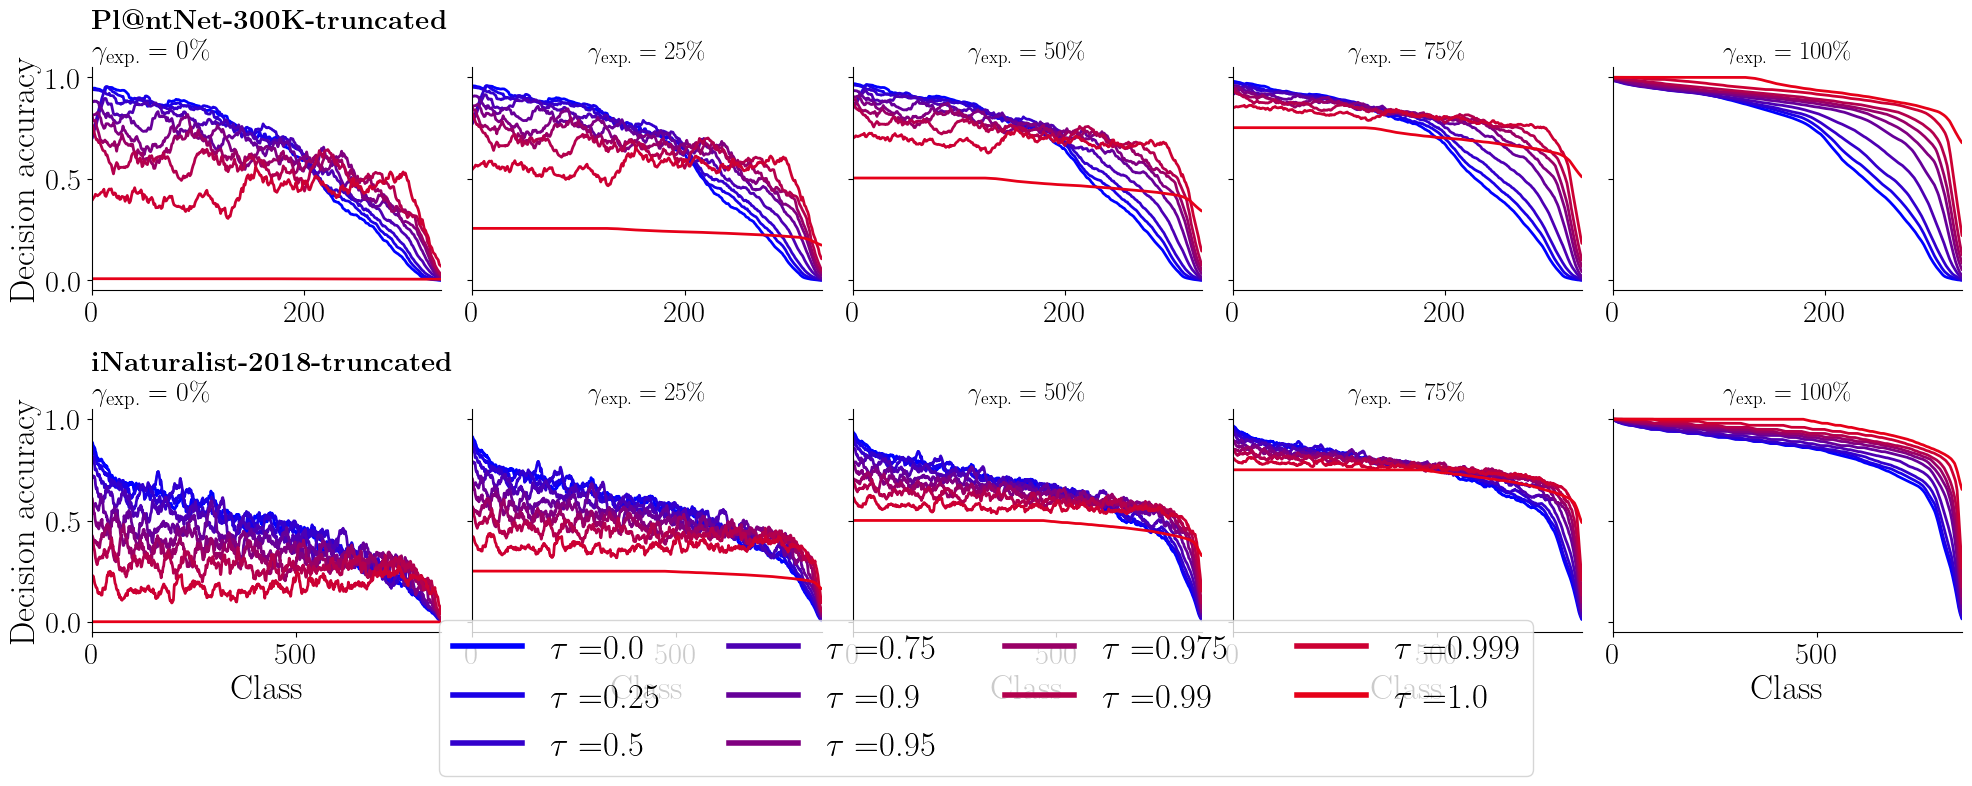

In [25]:
# # %%
# def create_methods_comparison_plot():
#     """
#     Create a 2x5 subplot where:
#     - Rows: datasets (plantnet-trunc, inaturalist-trunc)  
#     - Columns: fixed gamma levels (0%, 25%, 50%, 75%, 100%)
#     - Each subplot shows 4 methods as lines with the EXACT same curves as create_combined_decision_acc_plot
#     - Uses the same colors and smoothing as the original function
#     """
#     # Create 2x5 subplot layout
#     fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
    
#     datasets = ['plantnet-trunc', 'inaturalist-trunc']
#     gamma_levels = [0.0, 0.25, 0.5, 0.75, 1.0]  # 0%, 25%, 50%, 75%, 100%
    
#     # Use colorblind-friendly colors for each method
#     # Use the same colors and legend labels as in pareto_plots.py
#     # method_colors = {
#     #     'standard': 'blue',
#     #     'classwise': 'red',
#     #     'clustered': 'purple',
#     #     'prevalence-adjusted': 'orange',
#     # }

#     # ------- FOR INTERP-Q SPECIFICALLY ------
#     method_colors = {}
#     method_to_name = {}
#     M = len(methods)
#     for i, item in enumerate(methods):
#         # Extract weight as float
#         w = float(item.split("=")[1])
#         method_colors[item] = (i/M, 0, 1-i/M)
#         method_to_name[item] = f'$\\tau=${w}'
#     # --------------------------------------
    
#     for row, dataset_name in enumerate(datasets):
#         # Load test labels for this dataset
#         test_labels_path = f'/home-warm/plantnet/conformal_cache/train_models/best-{dataset_name}-model_test_labels.npy'
#         test_labels = np.load(test_labels_path)
#         num_classes = np.max(test_labels) + 1
#         # Load results for this dataset
#         res = {}
#         for method in methods:
#             res[method] = load_metrics(dataset_name, 0.1, method)
#         # Add class-conditional decision accuracies
#         for method in methods:
#             dec_acc = compute_class_cond_decision_accuracy_for_method(res, method, test_labels)
#             res[method]['class-cond-decision-accuracy'] = dec_acc
#         for col, gamma in enumerate(gamma_levels):
#             ax = axes[row, col]
#             # Plot each method for this gamma level
#             for method in methods:
#                 idx = np.argsort(res[method]['coverage_metrics']['raw_class_coverages'])[::-1]
#                 up_line_raw = res[method]['class-cond-decision-accuracy'][idx]
#                 lower_line_raw = res[method]['coverage_metrics']['raw_class_coverages'][idx]
#                 line_data = uniform_filter((1-gamma) * up_line_raw + gamma * lower_line_raw, size=20, mode='nearest')
#                 color = method_colors[method]
#                 ax.plot(line_data, color=color, linewidth=2, 
#                         # linewidth=4.0, 
#                         label=method_to_name[method], solid_capstyle='round')
#             ax.set_xlim(0, num_classes-1)
#             ax.spines[['right', 'top']].set_visible(False)
#             # Set titles and labels
   

#             if col == 0:
#                 ax.set_title(f"\\textbf{{{dataset_names[dataset_name]}}}\n $\\gamma_{{\\mathrm{{exp.}}}} = {int(gamma*100)}\\%$", loc='left', fontsize=20, fontweight='bold')
#                 ax.set_ylabel('Decision accuracy', fontsize=25)
#             else:
#                 ax.set_title(f' $\\gamma_{{\\mathrm{{exp.}}}} = {int(gamma*100)}\\%$')
#             if row == 1:
#                 ax.set_xlabel('Class', fontsize=25)
#                 # (sorted by $\\hat{c}_y$ of each method)
#     # Move legend below the figure, centered, ncol=4 (like pareto_plots.py)
#     handles, labels = [], []
#     for method in methods:
#         handles.append(plt.Line2D([0], [0], color=method_colors[method], lw=4, label=method_to_name[method]))
#         labels.append(method_to_name[method])
#     plt.tight_layout(rect=[0, 0, 1, 0.93])
#     fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.08), fontsize=25, ncol=4, frameon=True)
#     # Save the combined plot
#     fig_path = f'{fig_folder}/methods_comparison_2x5.pdf'
#     plt.savefig(fig_path, bbox_inches='tight')
#     print('Saved methods comparison plot to', fig_path)
#     return fig, axes


# # Create the methods comparison plot
# create_methods_comparison_plot()

In [38]:
def create_methods_comparison_plots_separate():
    """
    Create two separate figures:
    1. plantnet-trunc (top row)
    2. inaturalist-trunc (bottom row)
    3. Legend only
    """
    import matplotlib.pyplot as plt
    from scipy.ndimage import uniform_filter
    datasets = ['plantnet-trunc', 'inaturalist-trunc']
    # methods = ['classwise', 'standard', 'prevalence-adjusted']
    gamma_levels = [0.0, 0.25, 0.5, 0.75, 1.0]

    # ------- FOR INTERP-Q SPECIFICALLY ------
    method_colors = {}
    method_to_name = {}
    M = len(methods)
    print(methods)
    for i, item in enumerate(methods):
        # Extract weight as float
        w = float(item.split("=")[1])
        method_colors[item] = (i/M, 0, 1-i/M)
        method_to_name[item] = f'$\\tau=$ {w}'
    # --------------------------------------
    
    fig_folder = get_figs_folder()
    for dataset_name in datasets:
        fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
        test_labels_path = f'/home-warm/plantnet/conformal_cache/train_models/best-{dataset_name}-model_test_labels.npy'
        test_labels = np.load(test_labels_path)
        num_classes = np.max(test_labels) + 1
        res = {}
        for method in methods:
            res[method] = load_metrics(dataset_name, 0.1, method)
        for method in methods:
            dec_acc = compute_class_cond_decision_accuracy_for_method(res, method, test_labels)
            res[method]['class-cond-decision-accuracy'] = dec_acc
        for col, gamma in enumerate(gamma_levels):
            ax = axes[col]
            for method in methods:
                idx = np.argsort(res[method]['coverage_metrics']['raw_class_coverages'])[::-1]
                up_line_raw = res[method]['class-cond-decision-accuracy'][idx]
                lower_line_raw = res[method]['coverage_metrics']['raw_class_coverages'][idx]
                line_data = uniform_filter((1-gamma) * up_line_raw + gamma * lower_line_raw, size=20, mode='nearest')
                color = method_colors[method]
                ax.plot(line_data, color=color, linewidth=4.0,
                linestyle='-',
                label=method_to_name[method], solid_capstyle='round')
            ax.set_xlim(0, num_classes-1)
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_title(f'$\\gamma_{{\\mathrm{{exp.}}}} = {int(gamma*100)}\\%$', fontsize=30)
            if col == 0:
                ax.set_ylabel('Decision accuracy', fontsize=25)
            ax.set_xlabel('Class', fontsize=25)
        fig.suptitle(dataset_names[dataset_name], y=0.95, fontsize=30)
        plt.tight_layout()
        # plt.tight_layout(rect=[0, 0, 1, 0.93])
        fig_path = f'{fig_folder}/interpQ_decision_accuracy_{dataset_name}.pdf'
        fig.savefig(fig_path, bbox_inches='tight')
        print(f'Saved plot for {dataset_name} to', fig_path)
        plt.close(fig)
    # --- Legend only ---
    handles, labels = [], []
    for method in methods:
        handles.append(plt.Line2D([0], [0], color=method_colors[method], lw=5, label=method_to_name[method]))
        labels.append(method_to_name[method])
    legend_fig = plt.figure(figsize=(12, 2))
    legend_fig.patch.set_visible(False)
    legend = legend_fig.legend(handles, labels, loc='center', fontsize=25, ncol=5, frameon=True)
    legend_fig.gca().set_axis_off()
    legend_path = f'{fig_folder}/interpQ_decision_accuracy_LEGEND_ONLY.pdf'
    legend_fig.savefig(legend_path, bbox_inches='tight', transparent=True)
    print('Saved legend only to', legend_path)
    plt.close(legend_fig)

# Create the separate plots
create_methods_comparison_plots_separate()

['cvx-cw_weight=0', 'cvx-cw_weight=0.25', 'cvx-cw_weight=0.5', 'cvx-cw_weight=0.75', 'cvx-cw_weight=0.9', 'cvx-cw_weight=0.95', 'cvx-cw_weight=0.975', 'cvx-cw_weight=0.99', 'cvx-cw_weight=0.999', 'cvx-cw_weight=1']


/tmp/ipykernel_2052273/1582642498.py:63: RuntimeWarning: divide by zero encountered in divide
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])
/tmp/ipykernel_2052273/1582642498.py:63: RuntimeWarning: invalid value encountered in multiply
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])


Saved plot for plantnet-trunc to ../figs/interpQ_decision_accuracy_plantnet-trunc.pdf
Saved plot for inaturalist-trunc to ../figs/interpQ_decision_accuracy_inaturalist-trunc.pdf
Saved legend only to ../figs/interpQ_decision_accuracy_LEGEND_ONLY.pdf
